# Adaptive LIF Neurons

Thusfar, in modeling leaky integrate-and-fire (LIF) neurons, the only state variable that we have been modifying has been its current voltage/potential. However, in some applications it can also be useful to allow the **threshold voltage** ($v_{th}$) to vary. Specifically, when there is a spike, we can slightly increase $v_{th}$ so that it is slightly more difficult to spike next time (i.e., it adapts to the level of input). We will call our new neuron model "Adaptive LIF" (ALIF).

The ALIF can be useful in a variety of scenarios, including cases where we want neurons to "fine tune" their behave to adapt to input that might otherwise be too "intense" (and thus result in too high of a firing rate if neurons don't adapt) and cases where we want to be sure that one neuron in a group doesn't get "greedy" for inputs with which it is closely aligned.

To implement ALIF neurons, we will create an additional state variable $w$ to represent how much the threshold voltage ($v_{th}$) has increased (meaning that we will spike only when $v \geq v_{th} + w$). $w$ will start as $0$ and increase every time our neuron fires. We also create a variable $b$ to represent the **strength of adaption**. When our ALIF spikes, we will increment $w$ by $b$. We will also introduce a time constant $\tau_w$ to specify how quickly $w$ decays back to $0$.

So now, rather than a static threshold $v_{th}$, we have a dynamic threshold, which we will call $\vartheta_{th}(t)$:

$\vartheta_{th}(t) = v_{th} + w(t)$

and our threshold changes over time by:

$\vartheta_{th}'(t) = -\frac{1}{\tau_w}w(t)$

if there is a spike at time $t$ then $w(t)$ increases by $b$.

To implement ALIF neurons, let's start by recalling the code that we had for LIF neurons:

In [1]:

class LIF:
    def __init__(self, n=1, dim=1, tau_rc=0.02, tau_ref=0.002, v_th=1, 
                 max_rates=[200, 400], intercept_range=[-1, 1], t_step=0.001, v_init = 0):
        self.n = n
        # Set neuron parameters
        self.dim = dim  # Dimensionality of the input
        self.tau_rc = tau_rc  # Membrane time constant
        self.tau_ref = tau_ref  # Refractory period
        self.v_th = np.ones(n) * v_th  # Threshold voltage for spiking
        self.t_step = t_step  # Time step for simulation
        
        # Initialize state variables
        self.voltage = np.ones(n) * v_init  # Initial voltage of neurons
        self.refractory_time = np.zeros(n)  # Time remaining in refractory period
        self.output = np.zeros(n)  # Output spikes

        # Generate random max rates and intercepts within the given range
        max_rates_tensor = np.random.uniform(max_rates[0], max_rates[1], n)
        intercepts_tensor = np.random.uniform(intercept_range[0], intercept_range[1], n)

        # Calculate gain and bias for each neuron
        self.gain = self.v_th * (1 - 1 / (1 - np.exp((self.tau_ref - 1/max_rates_tensor) / self.tau_rc))) / (intercepts_tensor - 1)
        self.bias = np.expand_dims(self.v_th - self.gain * intercepts_tensor, axis=1)
        
        # Initialize random encoders
        self.encoders = np.random.randn(n, self.dim)
        self.encoders /= np.linalg.norm(self.encoders, axis=1)[:, np.newaxis]

    def reset(self):
        # Reset the state variables to initial conditions
        self.voltage = np.zeros(self.n)
        self.refractory_time = np.zeros(self.n)
        self.output = np.zeros(self.n)

    def step(self, inputs):
        dt = self.t_step  # Time step

        # Update refractory time
        self.refractory_time -= dt
        delta_t = np.clip(dt - self.refractory_time, 0, dt) # ensure between 0 and dt

        # Calculate input current
        I = np.sum(self.bias + inputs * self.encoders * self.gain[:, np.newaxis], axis=0) / self.n

        # Update membrane potential
        self.voltage = I + (self.voltage - I) * np.exp(-delta_t / self.tau_rc)

        # Determine which neurons spike
        spike_mask = self.voltage > self.v_th
        self.output[:] = spike_mask / dt  # Record spikes in output

        # Calculate the time of the spike
        t_spike = self.tau_rc * np.log((self.voltage[spike_mask] - I[spike_mask]) / (self.v_th[spike_mask] - I[spike_mask])) + dt

        # Reset voltage of spiking neurons
        self.voltage[spike_mask] = 0

        # Set refractory time for spiking neurons
        self.refractory_time[spike_mask] = self.tau_ref + t_spike

        return self.output  # Return the output spikes

On top of this code, we will add:

- `inh` to represent $w$, a variable that tracks how much the threshold voltage (`v_th`) has increased (meaning that `v` will need to exceed `this.v_th + this.inh`)
- `tau_inh` to represent $\tau_w$, a time constant that tracks how `inh` should evolve over time
- `inc_inh` to represent $b$, which specifies how much to increase `inh` every time the neuron spikes

We can update our constructor to include defaults for `tau_inh` and `inc_inh` (`0.05` and `1` respectively):

```javascript
constructor(... tau_inh = 0.05, inc_inh = 1) ...
```

and initializing our instance variables (with `this.inh` initialized to `0`):

```python
self.inh = 0;
self.tau_inh = tau_inh;
self.inc_inh = inc_inh;
```

Now, we want to update our firing condition (`if(this.v > this.v_th)`) to add `this.inh`:

```python
    if self.v >= self.v_th + self.inh: #...
```

and we want to update `self.inh` every timestep:

```python
    self.inh = self.inh * (1 - t_step/self.tau_inh);
```

and if we fire:
```python
    if self.v >= self.v_th + self.inh:
        self.inh += self.inc_inh
        #...
```

Below is the full code with these changes incorporated:

In [2]:
import numpy as np

class ALIF:
    def __init__(self, n=1, dim=1, tau_rc=0.02, tau_ref=0.002, v_th=1, 
                 max_rates=[200, 400], intercept_range=[-1, 1], t_step=0.001, v_init = 0,
                 tau_inh=0.05, inc_inh=1.0 # <--- ADDED
                 ):
        self.n = n
        # Set neuron parameters
        self.dim = dim  # Dimensionality of the input
        self.tau_rc = tau_rc  # Membrane time constant
        self.tau_ref = tau_ref  # Refractory period
        self.v_th = np.ones(n) * v_th  # Threshold voltage for spiking
        self.t_step = t_step  # Time step for simulation

        self.inh = np.zeros(n)  # <--- ADDED
        self.tau_inh = tau_inh  # <--- ADDED
        self.inc_inh = inc_inh  # <--- ADDED
        
        # Initialize state variables
        self.voltage = np.ones(n) * v_init  # Initial voltage of neurons
        self.refractory_time = np.zeros(n)  # Time remaining in refractory period
        self.output = np.zeros(n)  # Output spikes

        # Generate random max rates and intercepts within the given range
        max_rates_tensor = np.random.uniform(max_rates[0], max_rates[1], n)
        intercepts_tensor = np.random.uniform(intercept_range[0], intercept_range[1], n)

        # Calculate gain and bias for each neuron
        self.gain = self.v_th * (1 - 1 / (1 - np.exp((self.tau_ref - 1/max_rates_tensor) / self.tau_rc))) / (intercepts_tensor - 1)
        self.bias = np.expand_dims(self.v_th - self.gain * intercepts_tensor, axis=1)
        
        # Initialize random encoders
        self.encoders = np.random.randn(n, self.dim)
        self.encoders /= np.linalg.norm(self.encoders, axis=1)[:, np.newaxis]

    def reset(self):
        # Reset the state variables to initial conditions
        self.voltage = np.zeros(self.n)
        self.refractory_time = np.zeros(self.n)
        self.output = np.zeros(self.n)
        self.inh = np.zeros(self.n)  # <--- ADDED

    def step(self, inputs):
        dt = self.t_step  # Time step

        # Update refractory time
        self.refractory_time -= dt
        delta_t = np.clip(dt - self.refractory_time, 0, dt) # ensure between 0 and dt

        # Calculate input current
        I = np.sum(self.bias + inputs * self.encoders * self.gain[:, np.newaxis], axis=1)

        # Update membrane potential
        self.voltage = I + (self.voltage - I) * np.exp(-delta_t / self.tau_rc)

        # Determine which neurons spike
        spike_mask = self.voltage > self.v_th + self.inh  # <--- ADDED + self.inh
        self.output[:] = spike_mask / dt  # Record spikes in output

        # Calculate the time of the spike
        t_spike = self.tau_rc * np.log((self.voltage[spike_mask] - I[spike_mask]) / (self.v_th[spike_mask] - I[spike_mask])) + dt

        # Reset voltage of spiking neurons
        self.voltage[spike_mask] = 0

        # Set refractory time for spiking neurons
        self.refractory_time[spike_mask] = self.tau_ref + t_spike

        self.inh = self.inh * np.exp(-dt / self.tau_inh) + self.inc_inh * (self.output > 0)  # <--- ADDED

        return self.output  # Return the output spikes

In [3]:

class LIF:
    def __init__(self, n=1, dim=1, tau_rc=0.02, tau_ref=0.002, v_th=1, 
                 max_rates=[200, 400], intercept_range=[-1, 1], t_step=0.001, v_init = 0):
        self.n = n
        # Set neuron parameters
        self.dim = dim  # Dimensionality of the input
        self.tau_rc = tau_rc  # Membrane time constant
        self.tau_ref = tau_ref  # Refractory period
        self.v_th = np.ones(n) * v_th  # Threshold voltage for spiking
        self.t_step = t_step  # Time step for simulation
        
        # Initialize state variables
        self.voltage = np.ones(n) * v_init  # Initial voltage of neurons
        self.refractory_time = np.zeros(n)  # Time remaining in refractory period
        self.output = np.zeros(n)  # Output spikes

        # Generate random max rates and intercepts within the given range
        max_rates_tensor = np.random.uniform(max_rates[0], max_rates[1], n)
        intercepts_tensor = np.random.uniform(intercept_range[0], intercept_range[1], n)

        # Calculate gain and bias for each neuron
        self.gain = self.v_th * (1 - 1 / (1 - np.exp((self.tau_ref - 1/max_rates_tensor) / self.tau_rc))) / (intercepts_tensor - 1)
        self.bias = np.expand_dims(self.v_th - self.gain * intercepts_tensor, axis=1)
        
        # Initialize random encoders
        self.encoders = np.random.randn(n, self.dim)
        self.encoders /= np.linalg.norm(self.encoders, axis=1)[:, np.newaxis]

    def reset(self):
        # Reset the state variables to initial conditions
        self.voltage = np.zeros(self.n)
        self.refractory_time = np.zeros(self.n)
        self.output = np.zeros(self.n)

    def step(self, inputs):
        dt = self.t_step  # Time step

        # Update refractory time
        self.refractory_time -= dt
        delta_t = np.clip(dt - self.refractory_time, 0, dt) # ensure between 0 and dt

        # Calculate input current
        I = np.sum(self.bias + inputs * self.encoders * self.gain[:, np.newaxis], axis=0) / self.n

        # Update membrane potential
        self.voltage = I + (self.voltage - I) * np.exp(-delta_t / self.tau_rc)

        # Determine which neurons spike
        spike_mask = self.voltage > self.v_th
        self.output[:] = spike_mask / dt  # Record spikes in output

        # Calculate the time of the spike
        t_spike = self.tau_rc * np.log((self.voltage[spike_mask] - I[spike_mask]) / (self.v_th[spike_mask] - I[spike_mask])) + dt

        # Reset voltage of spiking neurons
        self.voltage[spike_mask] = 0

        # Set refractory time for spiking neurons
        self.refractory_time[spike_mask] = self.tau_ref + t_spike

        return self.output  # Return the output spikes

Let's see what this looks like with `tau_inh = 0.3` and `inc_inh = 0.2` over a short time period (0.5 seconds). Note that we reduced the neuron's refractory period so that the effect is more visible:

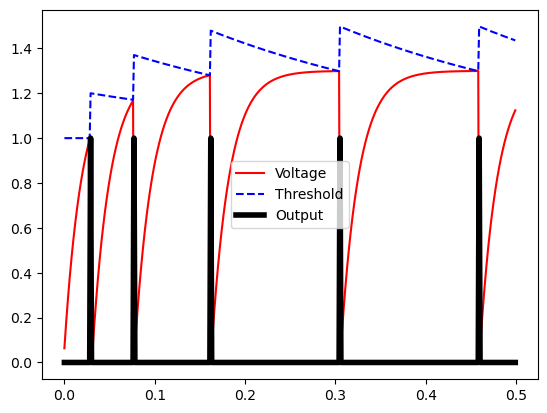

In [4]:
import matplotlib.pyplot as plt

T = 5
t_step = 0.001
neurons = ALIF(n=1, t_step=t_step, tau_inh=0.3, inc_inh=0.2)
neurons.bias = np.array([0]) ; neurons.gain = np.array([1]) ; neurons.encoders = np.array([[1]]) # Remove the random gain, bias, and encoders

times = np.arange(0, T, t_step)
inp = 1.3

outputs = []
for t in times:
    neurons.step(inp)
    outputs.append((neurons.voltage[0], neurons.v_th[0] + neurons.inh[0], neurons.output[0]))

short_n = round(0.5 / t_step)
plt.figure()
plt.plot(times[:short_n], [o[0] for o in outputs[:short_n]], color='red', label='Voltage')
plt.plot(times[:short_n], [o[1] for o in outputs[:short_n]], color='blue', label='Threshold', linestyle='--')
plt.plot(times[:short_n], [o[2] * t_step for o in outputs[:short_n]], linewidth=4, color='black', label='Output')
plt.legend()
plt.show()

Note that at first, the neuron spikes quickly but then spikes become more spaced out over time. The firing speed does become more regular over the long term, as our threshold and voltage "balance" out. Let's look over a period of 5 seconds:

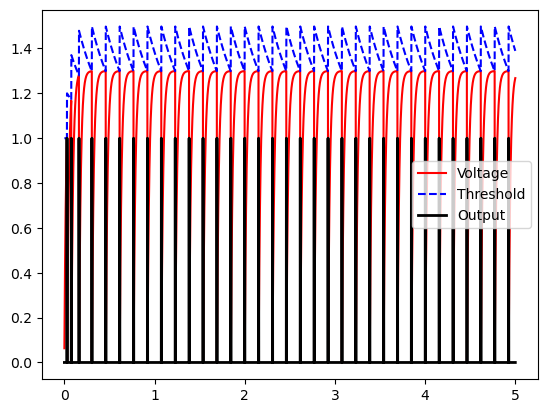

In [5]:
plt.figure()
plt.plot(times, [o[0] for o in outputs], color='red', label='Voltage')
plt.plot(times, [o[1] for o in outputs], color='blue', label='Threshold', linestyle='--')
plt.plot(times, [o[2] * t_step for o in outputs], linewidth=2, color='black', label='Output')
plt.legend()
plt.show()

Finally, we claimed that part of the motivation for using ALIFs is that their firing rate can be less sensitive to input variability...so let's test this. Again, to make the difference more visible, we are going to tune a parameter of our ALIF neurons...we are going to increase `tau_inh` to `0.7` so that the additional inhibition stays for "longer" after it is increased.

In [6]:
def plotFiringRates(tau_inh, inc_inh):
    t_step = 0.001
    def getFiringRate(inp, neuron, runtime=10):
        times = np.arange(0, runtime, t_step)
        num_spikes = 0
        for t in times:
            neuron.step(inp)
            if neuron.output[0] > 0:
                num_spikes += 1
        return num_spikes / runtime

    alifs = ALIF(n=1, tau_ref=0.002, tau_rc=0.2, t_step=t_step, tau_inh=tau_inh, inc_inh=inc_inh)
    lifs  =  LIF(n=1, tau_ref=0.002, tau_rc=0.2, t_step=t_step)

    alifs.bias = lifs.bias = np.array([0]) ; alifs.gain = lifs.gain = np.array([1]) ; alifs.encoders = lifs.encoders = np.array([[1]]) # Remove the random gain, bias, and encoders

    rates = []

    for inp in np.linspace(0.9, 2, 100):
        alifFiringRate = getFiringRate(inp, alifs)
        lifFiringRate  = getFiringRate(inp, lifs)

        alifs.reset() ; lifs.reset()
        rates.append((inp, alifFiringRate, lifFiringRate))

    plt.figure()
    plt.plot([r[0] for r in rates], [r[1] for r in rates], label='ALIF')
    plt.plot([r[0] for r in rates], [r[2] for r in rates], label='LIF')
    plt.legend()
    plt.show()

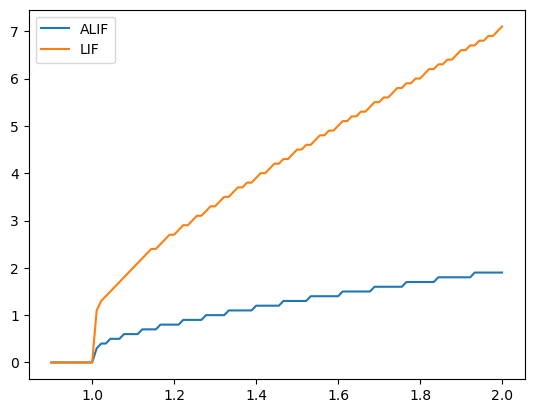

In [7]:
plotFiringRates(tau_inh=0.7, inc_inh=1.0)

<!-- ```{editor} python
:packages: matplotlib,numpy
:run_on_load: true
:max_height: 600px

import numpy as np
import matplotlib.pyplot as plt

tau_inh =  0.50 #<-SLIDE(0 to  1 by 0.001)
inc_inc =  0.10 #<-SLIDE(0 to 20 by 0.01)

class ALIF:
    def __init__(self, n=1, dim=1, tau_rc=0.02, tau_ref=0.002, v_th=1, 
                 max_rates=[200, 400], intercept_range=[-1, 1], t_step=0.001, v_init = 0,
                 tau_inh=0.05, inc_inh=1.0 # <--- ADDED
                 ):
        self.n = n
        # Set neuron parameters
        self.dim = dim  # Dimensionality of the input
        self.tau_rc = tau_rc  # Membrane time constant
        self.tau_ref = tau_ref  # Refractory period
        self.v_th = np.ones(n) * v_th  # Threshold voltage for spiking
        self.t_step = t_step  # Time step for simulation

        self.inh = np.zeros(n)  # <--- ADDED
        self.tau_inh = tau_inh  # <--- ADDED
        self.inc_inh = inc_inh  # <--- ADDED
        
        # Initialize state variables
        self.voltage = np.ones(n) * v_init  # Initial voltage of neurons
        self.refractory_time = np.zeros(n)  # Time remaining in refractory period
        self.output = np.zeros(n)  # Output spikes

        # Generate random max rates and intercepts within the given range
        max_rates_tensor = np.random.uniform(max_rates[0], max_rates[1], n)
        intercepts_tensor = np.random.uniform(intercept_range[0], intercept_range[1], n)

        # Calculate gain and bias for each neuron
        self.gain = self.v_th * (1 - 1 / (1 - np.exp((self.tau_ref - 1/max_rates_tensor) / self.tau_rc))) / (intercepts_tensor - 1)
        self.bias = np.expand_dims(self.v_th - self.gain * intercepts_tensor, axis=1)
        
        # Initialize random encoders
        self.encoders = np.random.randn(n, self.dim)
        self.encoders /= np.linalg.norm(self.encoders, axis=1)[:, np.newaxis]

    def reset(self):
        # Reset the state variables to initial conditions
        self.voltage = np.zeros(self.n)
        self.refractory_time = np.zeros(self.n)
        self.output = np.zeros(self.n)
        self.inh = np.zeros(self.n)  # <--- ADDED

    def step(self, inputs):
        dt = self.t_step  # Time step

        # Update refractory time
        self.refractory_time -= dt
        delta_t = np.clip(dt - self.refractory_time, 0, dt) # ensure between 0 and dt

        # Calculate input current
        I = np.sum(self.bias + inputs * self.encoders * self.gain[:, np.newaxis], axis=1)

        # Update membrane potential
        self.voltage = I + (self.voltage - I) * np.exp(-delta_t / self.tau_rc)

        # Determine which neurons spike
        spike_mask = self.voltage > self.v_th + self.inh  # <--- ADDED + self.inh
        self.output[:] = spike_mask / dt  # Record spikes in output

        # Calculate the time of the spike
        t_spike = self.tau_rc * np.log((self.voltage[spike_mask] - I[spike_mask]) / (self.v_th[spike_mask] - I[spike_mask])) + dt

        # Reset voltage of spiking neurons
        self.voltage[spike_mask] = 0

        # Set refractory time for spiking neurons
        self.refractory_time[spike_mask] = self.tau_ref + t_spike

        self.inh = self.inh * np.exp(-dt / self.tau_inh) + self.inc_inh * (self.output > 0)  # <--- ADDED

        return self.output  # Return the output spikes

class LIF:
    def __init__(self, n=1, dim=1, tau_rc=0.02, tau_ref=0.002, v_th=1, 
                 max_rates=[200, 400], intercept_range=[-1, 1], t_step=0.001, v_init = 0):
        self.n = n
        # Set neuron parameters
        self.dim = dim  # Dimensionality of the input
        self.tau_rc = tau_rc  # Membrane time constant
        self.tau_ref = tau_ref  # Refractory period
        self.v_th = np.ones(n) * v_th  # Threshold voltage for spiking
        self.t_step = t_step  # Time step for simulation
        
        # Initialize state variables
        self.voltage = np.ones(n) * v_init  # Initial voltage of neurons
        self.refractory_time = np.zeros(n)  # Time remaining in refractory period
        self.output = np.zeros(n)  # Output spikes

        # Generate random max rates and intercepts within the given range
        max_rates_tensor = np.random.uniform(max_rates[0], max_rates[1], n)
        intercepts_tensor = np.random.uniform(intercept_range[0], intercept_range[1], n)

        # Calculate gain and bias for each neuron
        self.gain = self.v_th * (1 - 1 / (1 - np.exp((self.tau_ref - 1/max_rates_tensor) / self.tau_rc))) / (intercepts_tensor - 1)
        self.bias = np.expand_dims(self.v_th - self.gain * intercepts_tensor, axis=1)
        
        # Initialize random encoders
        self.encoders = np.random.randn(n, self.dim)
        self.encoders /= np.linalg.norm(self.encoders, axis=1)[:, np.newaxis]

    def reset(self):
        # Reset the state variables to initial conditions
        self.voltage = np.zeros(self.n)
        self.refractory_time = np.zeros(self.n)
        self.output = np.zeros(self.n)

    def step(self, inputs):
        dt = self.t_step  # Time step

        # Update refractory time
        self.refractory_time -= dt
        delta_t = np.clip(dt - self.refractory_time, 0, dt) # ensure between 0 and dt

        # Calculate input current
        I = np.sum(self.bias + inputs * self.encoders * self.gain[:, np.newaxis], axis=1)

        # Update membrane potential
        self.voltage = I + (self.voltage - I) * np.exp(-delta_t / self.tau_rc)

        # Determine which neurons spike
        spike_mask = self.voltage > self.v_th
        self.output[:] = spike_mask / dt  # Record spikes in output

        # Calculate the time of the spike
        t_spike = self.tau_rc * np.log((self.voltage[spike_mask] - I[spike_mask]) / (self.v_th[spike_mask] - I[spike_mask])) + dt

        # Reset voltage of spiking neurons
        self.voltage[spike_mask] = 0

        # Set refractory time for spiking neurons
        self.refractory_time[spike_mask] = self.tau_ref + t_spike

        return self.output  # Return the output spikes

t_step = 0.001
def getFiringRate(inp, neuron, runtime=10):
    times = np.arange(0, runtime, t_step)
    num_spikes = 0
    for t in times:
        neuron.step(inp)
        if neuron.output[0] > 0:
            num_spikes += 1
    return num_spikes / runtime

alifs = ALIF(n=1, tau_ref=0.002, tau_rc=0.2, t_step=t_step, tau_inh=tau_inh, inc_inh=inc_inh)
lifs  =  LIF(n=1, tau_ref=0.002, tau_rc=0.2, t_step=t_step)

alifs.bias = lifs.bias = np.array([0]) ; alifs.gain = lifs.gain = np.array([1]) ; alifs.encoders = lifs.encoders = np.array([[1]]) # Remove the random gain, bias, and encoders

rates = []

for inp in np.linspace(0.9, 2, 200):
    alifFiringRate = getFiringRate(inp, alifs)
    lifFiringRate  = getFiringRate(inp, lifs)

    alifs.reset() ; lifs.reset()
    rates.append((inp, alifFiringRate, lifFiringRate))

plt.figure()
plt.plot([r[0] for r in rates], [r[1] for r in rates], label='ALIF')
plt.plot([r[0] for r in rates], [r[2] for r in rates], label='LIF')
plt.legend()
plt.show()
``` -->

Note here how the ALIF (blue line) is less sensitive to changes in input than the normal LIF. If we decrease `tau_inh`, our ALIF behaves more and more like the LIF model (since the inhibition disappears more quickly).

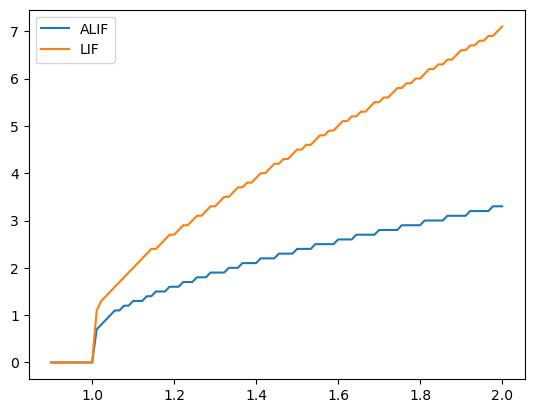

In [8]:
plotFiringRates(tau_inh=0.3, inc_inh=1.0)

Similarly, if we decrease `inc_inh`, our ALIF behaves more and more like the LIF model (since the inhibition changes less).

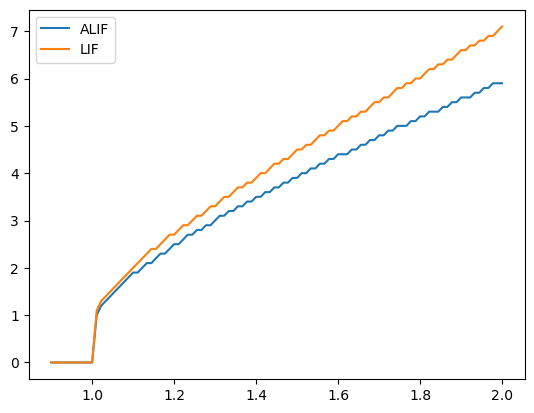

In [9]:
plotFiringRates(tau_inh=0.3, inc_inh=0.1)

## Summary

- Adaptive LIF neurons introduce a variable firing threshold $\vartheta_{th}(t) = v_{th} + w(t)$
  - $v_{th}$ is the "original" firing threshold
  - $w_{t}$ is an additional threshold that changes over time: $w'(t) = -\frac{1}{\tau_w}w(t)$
      - $\tau_w$ is a time constant that controls how quickly $w(t)$ decays
      - if there is a spike at time $t$ then $w(t)$ increases by some constant $b$.
- Adaptive LIFs can help us make our LIFs' firing rate less sensitive to input variability